<a href="https://colab.research.google.com/github/MarinaChau/IASD_classes/blob/master/Project%20Adversarial%20Attack/Attack_Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [13]:
from google.colab import drive
drive.mount('myDrive')

Mounted at myDrive


# Project Adversarial Attack

Team members: Marina, Alice, Noé and Théo


## Part 1

### 1.1 Code `∞-PGD attack & Observe robustness of neural networks


### a. Create a simple classifier on Cifar10

In [1]:
# import standard libraries

import tensorflow as tf
import seaborn as sns
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import itertools

print(tf.__version__)

2.8.0


#### CIFAR10 Classes

0. airplane
1. automobile
2. bird
3. cat
4. deer
5. dog
6. frog
7. horse
8. ship
9. truck

#### Load dataset

In [2]:
cifar10 = tf.keras.datasets.cifar10
(x_train, y_train), (x_test, y_test) = cifar10.load_data()

170508288/170498071 [==============================] - 16s 0us/step


In [3]:
y_train = y_train.flatten()
y_test = y_test.flatten()

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


[[Text(0, 0, 'airplane'),
  Text(0, 0, 'automobile'),
  Text(0, 0, 'bird'),
  Text(0, 0, 'cat'),
  Text(0, 0, 'deer'),
  Text(0, 0, 'dog'),
  Text(0, 0, 'frog'),
  Text(0, 0, 'horse'),
  Text(0, 0, 'ship'),
  Text(0, 0, 'truck')]]

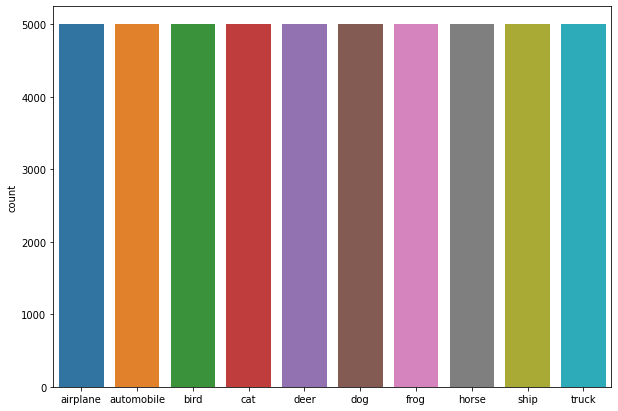

In [4]:
classes = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

plt.figure(figsize=(10,7))
p = sns.countplot(y_train.flatten())
p.set(xticklabels=classes)

In [5]:
# Check for Nan
print(np.isnan(x_train).any())
print(np.isnan(x_test).any())

False
False


In [6]:
# Normalize the dataset
input_shape = (32, 32, 3)

x_train=x_train.reshape(x_train.shape[0], x_train.shape[1], x_train.shape[2], 3)
x_train=x_train / 255.0
x_test = x_test.reshape(x_test.shape[0], x_test.shape[1], x_test.shape[2], 3)
x_test=x_test / 255.0

In [7]:
# Label encoding
y_train = tf.one_hot(y_train.astype(np.int32), depth=10)
y_test = tf.one_hot(y_test.astype(np.int32), depth=10)

tf.Tensor([0. 0. 0. 0. 0. 0. 0. 0. 1. 0.], shape=(10,), dtype=float32)


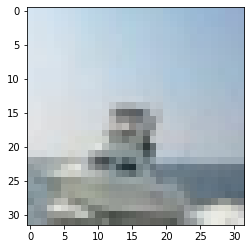

In [8]:
# Visualize data for check
plt.imshow(x_train[100])
print(y_train[100])

#### Building the model

In [9]:
def build_model(batch_size, num_classes, epochs, learning_rate=0.0001, decay=1e-06):

    inputs = tf.keras.Input(shape=x_train.shape[1:])
    x = tf.keras.layers.Conv2D(32, 3, padding='same', activation='relu')(inputs)
    x = tf.keras.layers.Conv2D(32, 3, padding='same', activation='relu')(x)
    x = tf.keras.layers.MaxPooling2D()(x)
    x = tf.keras.layers.Dropout(0.25)(x)
    x = tf.keras.layers.Conv2D(64, 3, padding='same', activation='relu')(x)
    x = tf.keras.layers.Conv2D(64, 3, activation='relu')(x)
    x = tf.keras.layers.MaxPooling2D()(x)
    x = tf.keras.layers.Dropout(0.25)(x)
    x = tf.keras.layers.Flatten()(x)
    x = tf.keras.layers.Dense(512, activation='relu')(x)
    x = tf.keras.layers.Dropout(0.5)(x)
    outputs = tf.keras.layers.Dense(num_classes, activation='softmax')(x)

    model = tf.keras.Model(inputs=inputs, outputs=outputs, name="cifar_classifier")
    model.compile(optimizer=tf.keras.optimizers.RMSprop(learning_rate=0.0001, decay=1e-06),
            loss='categorical_crossentropy', metrics=['acc'])
    
    model.summary()

    return model

In [10]:
# Defining and build the model
batch_size = 32
num_classes = 10
epochs = 50

model_1 = build_model(batch_size, num_classes, epochs)

Model: "cifar_classifier"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 32, 32, 3)]       0         
                                                                 
 conv2d (Conv2D)             (None, 32, 32, 32)        896       
                                                                 
 conv2d_1 (Conv2D)           (None, 32, 32, 32)        9248      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 16, 16, 32)       0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 16, 16, 32)        0         
                                                                 
 conv2d_2 (Conv2D)           (None, 16, 16, 64)        18496     
                                                  

#### Train the model

In [11]:
history = model_1.fit(x_train, y_train, batch_size=batch_size,
                    epochs=epochs)

Epoch 1/50
1563/1563 [==============================] - 21s 6ms/step - loss: 1.7827 - acc: 0.3452
Epoch 2/50
1563/1563 [==============================] - 9s 6ms/step - loss: 1.4458 - acc: 0.4753
Epoch 3/50
1563/1563 [==============================] - 9s 6ms/step - loss: 1.3015 - acc: 0.5322
Epoch 4/50
1563/1563 [==============================] - 9s 6ms/step - loss: 1.2029 - acc: 0.5714
Epoch 5/50
1563/1563 [==============================] - 9s 6ms/step - loss: 1.1230 - acc: 0.6027
Epoch 6/50
1563/1563 [==============================] - 9s 6ms/step - loss: 1.0598 - acc: 0.6261
Epoch 7/50
1563/1563 [==============================] - 9s 6ms/step - loss: 1.0071 - acc: 0.6456
Epoch 8/50
1563/1563 [==============================] - 9s 6ms/step - loss: 0.9666 - acc: 0.6618
Epoch 9/50
1563/1563 [==============================] - 9s 6ms/step - loss: 0.9266 - acc: 0.6751
Epoch 10/50
1563/1563 [==============================] - 10s 7ms/step - loss: 0.8922 - acc: 0.6881
Epoch 11/50
1563/1563 [====

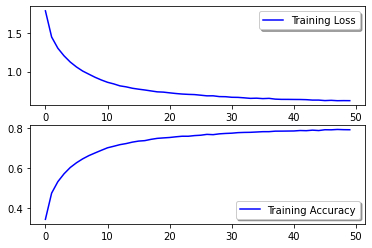

In [12]:
fig, ax = plt.subplots(2,1)
ax[0].plot(history.history['loss'], color='b', label="Training Loss")
legend = ax[0].legend(loc='best', shadow=True)

ax[1].plot(history.history['acc'], color='b', label="Training Accuracy")
legend = ax[1].legend(loc='best', shadow=True)

In [17]:
# save model
import os
model_save_path = "content/myDrive/MyDrive/Projet DL/model_CIFAR10.h5"
print(os.path.exists(model_save_path))
model_1.save(model_save_path)

True


#### Test and evaluate



In [19]:
test_loss, test_acc = model_1.evaluate(x_test, y_test)

313/313 [==============================] - 2s 5ms/step - loss: 0.6780 - acc: 0.7802


In [21]:
# Predict the values from the validation dataset
y_pred = model_1.predict(x_test)
# Convert predictions classes to one hot vectors 
y_pred_classes = np.argmax(y_pred,axis = 1) 
# Convert validation observations to one hot vectors
y_true = np.argmax(y_test,axis = 1)
# compute the confusion matrix
confusion_mtx = tf.math.confusion_matrix(y_true, y_pred_classes)

[[Text(0, 0.5, 'airplane'),
  Text(0, 1.5, 'automobile'),
  Text(0, 2.5, 'bird'),
  Text(0, 3.5, 'cat'),
  Text(0, 4.5, 'deer'),
  Text(0, 5.5, 'dog'),
  Text(0, 6.5, 'frog'),
  Text(0, 7.5, 'horse'),
  Text(0, 8.5, 'ship'),
  Text(0, 9.5, 'truck')],
 [Text(0.5, 0, 'airplane'),
  Text(1.5, 0, 'automobile'),
  Text(2.5, 0, 'bird'),
  Text(3.5, 0, 'cat'),
  Text(4.5, 0, 'deer'),
  Text(5.5, 0, 'dog'),
  Text(6.5, 0, 'frog'),
  Text(7.5, 0, 'horse'),
  Text(8.5, 0, 'ship'),
  Text(9.5, 0, 'truck')]]

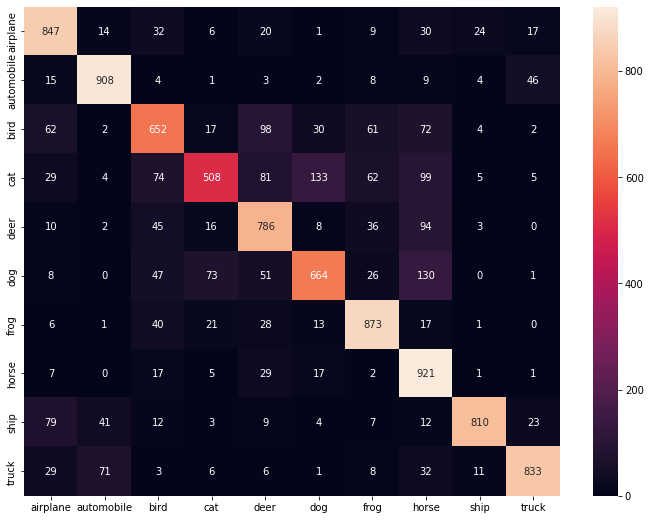

In [23]:
plt.figure(figsize=(12, 9))
c = sns.heatmap(confusion_mtx, annot=True, fmt='g')
c.set(xticklabels=classes, yticklabels=classes)

### 1.2 Code Adversarial training & Observe robustness of neural networks